In [11]:
import click
import logging
from pathlib import Path
#from dotenv import find_dotenv, load_dotenv

from dask.distributed import Client
import dask.dataframe as dd

import seaborn as sns

In [4]:
client = Client(n_workers=3, threads_per_worker = 2, memory_limit='4G')
client

/home/yannik/anaconda3/envs/bigdata/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41481 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:41481/status,
Dashboard: http://127.0.0.1:41481/status,Workers: 3
Total threads: 6,Total memory: 11.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45931,Workers: 3
Dashboard: http://127.0.0.1:41481/status,Total threads: 6
Started: Just now,Total memory: 11.18 GiB
Comm: tcp://127.0.0.1:42403,Total threads: 2
Dashboard: http://127.0.0.1:45345/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:46809,


In [5]:
input_filepath = '../data/processed/parking_violations_issued_2023.parquet'

In [6]:
ddf = dd.read_parquet(input_filepath)

In [28]:
ddf['issue_date'].dtype

dtype('<M8[ns]')

In [51]:
# Aggregate number of tickets per day
ddf_aggregated = ddf[['summons_number','issue_date']].groupby(['issue_date']).count().compute().sort_index()

ddf_aggregated.head()

,summons_number
issue_date,
1972-04-04,1
1972-09-02,1
1972-11-09,1
1972-11-21,1
2000-01-06,1


In [37]:
from datetime import datetime

In [52]:
ddf_aggregated = ddf_aggregated[ddf_aggregated.index >= datetime(2022, 6, 1)]

In [53]:
ddf_aggregated

,summons_number
issue_date,
2022-06-01,68
2022-06-02,229
2022-06-03,175
2022-06-04,207
2022-06-05,1242
...,...
2023-05-25,1
2023-05-27,1
2023-06-01,1


<Axes: xlabel='issue_date', ylabel='summons_number'>

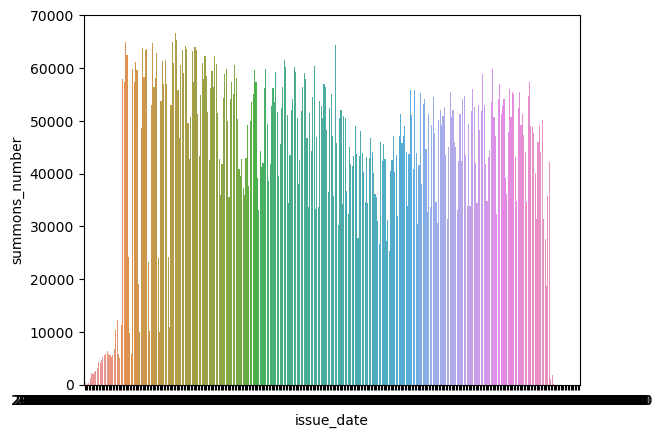

In [54]:
sns.barplot(x=ddf_aggregated.index, y=ddf_aggregated['summons_number'])

In [66]:
from meteostat import Stations, Daily, Point

# Set time period
start = datetime(2022, 6, 1)
end = datetime.now()

newyork = Point(40.7143, -74.006, 57)

# Get daily data
data = Daily(newyork, start, end)

In [67]:
weather_data = data.fetch()

In [68]:
weather_data

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2022-06-01,17.9,15.8,21.0,1.3,0.0,96.0,15.9,NaN,1013.7,NaN
2022-06-02,20.0,15.9,26.9,21.3,0.0,220.0,6.4,NaN,1007.3,NaN
2022-06-03,20.2,18.0,24.5,0.4,0.0,55.0,7.6,NaN,1007.6,NaN
2022-06-04,20.3,14.2,25.3,0.0,0.0,336.0,7.4,NaN,1011.4,NaN
2022-06-05,20.6,16.9,25.3,0.5,0.0,166.0,10.0,NaN,1015.7,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-06-04,15.8,11.4,20.7,0.0,NaN,42.0,12.8,NaN,1016.7,NaN
2023-06-05,19.0,14.1,24.1,0.0,NaN,337.0,6.8,NaN,1011.6,NaN
2023-06-06,20.3,16.9,26.9,0.4,NaN,301.0,9.6,NaN,1004.9,NaN


In [69]:
ddf_aggregated.join(weather_data)

,summons_number,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
issue_date,,,,,,,,,,,
2022-06-01,68,17.9,15.8,21.0,1.3,0.0,96.0,15.9,NaN,1013.7,NaN
2022-06-02,229,20.0,15.9,26.9,21.3,0.0,220.0,6.4,NaN,1007.3,NaN
2022-06-03,175,20.2,18.0,24.5,0.4,0.0,55.0,7.6,NaN,1007.6,NaN
2022-06-04,207,20.3,14.2,25.3,0.0,0.0,336.0,7.4,NaN,1011.4,NaN
2022-06-05,1242,20.6,16.9,25.3,0.5,0.0,166.0,10.0,NaN,1015.7,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-05-25,1,15.8,10.8,20.8,0.0,0.0,46.0,12.7,NaN,1020.4,NaN
2023-05-27,1,19.2,15.3,24.7,0.0,0.0,155.0,8.3,NaN,1025.9,NaN
2023-06-01,1,20.6,15.7,27.7,0.0,0.0,284.0,6.2,NaN,1018.9,NaN


In [71]:
import pandas as pd

In [76]:
events = pd.read_csv("https://data.cityofnewyork.us/api/views/tvpp-9vvx/rows.csv", index_col='Event ID')

In [77]:
events

,Event Name,Start Date/Time,End Date/Time,Event Agency,Event Type,Event Borough,Event Location,Event Street Side,Street Closure Type,Community Board,Police Precinct
Event ID,,,,,,,,,,,
462592,Event Space Conflicts,05/06/2023 06:00:00 AM,05/06/2023 11:00:00 PM,Parks Department,Special Event,Manhattan,Randall's Island Park: Hell Gate Fields-Soccer...,NaN,NaN,"11,","25,"
462592,Event Space Conflicts,05/07/2023 06:00:00 AM,05/07/2023 11:00:00 PM,Parks Department,Special Event,Manhattan,Randall's Island Park: Hell Gate Fields-Soccer...,NaN,NaN,"11,","25,"
462592,Event Space Conflicts,05/08/2023 06:00:00 AM,05/08/2023 11:00:00 PM,Parks Department,Special Event,Manhattan,Randall's Island Park: Hell Gate Fields-Soccer...,NaN,NaN,"11,","25,"
462592,Event Space Conflicts,05/09/2023 06:00:00 AM,05/09/2023 11:00:00 PM,Parks Department,Special Event,Manhattan,Randall's Island Park: Hell Gate Fields-Soccer...,NaN,NaN,"11,","25,"
462592,Event Space Conflicts,05/10/2023 06:00:00 AM,05/10/2023 11:00:00 PM,Parks Department,Special Event,Manhattan,Randall's Island Park: Hell Gate Fields-Soccer...,NaN,NaN,"11,","25,"
...,...,...,...,...,...,...,...,...,...,...,...
712761,Football ?�� Flag Football,05/12/2023 08:00:00 AM,05/12/2023 08:00:00 PM,Parks Department,Sport - Youth,Brooklyn,P.O. Reinaldo Salgado Playground (PS 309): Foo...,NaN,NaN,"03,","81,"
712761,Football ?�� Flag Football,05/19/2023 08:00:00 AM,05/19/2023 08:00:00 PM,Parks Department,Sport - Youth,Brooklyn,P.O. Reinaldo Salgado Playground (PS 309): Foo...,NaN,NaN,"03,","81,"
712761,Football ?�� Flag Football,05/26/2023 08:00:00 AM,05/26/2023 08:00:00 PM,Parks Department,Sport - Youth,Brooklyn,P.O. Reinaldo Salgado Playground (PS 309): Foo...,NaN,NaN,"03,","81,"


In [79]:
events['start_date'] = pd.to_datetime(events['Start Date/Time'])

In [81]:
events['date_only'] = events['start_date'].dt.date

In [82]:
events

,Event Name,Start Date/Time,End Date/Time,Event Agency,Event Type,Event Borough,Event Location,Event Street Side,Street Closure Type,Community Board,Police Precinct,start_date,date_only
Event ID,,,,,,,,,,,,,
462592,Event Space Conflicts,05/06/2023 06:00:00 AM,05/06/2023 11:00:00 PM,Parks Department,Special Event,Manhattan,Randall's Island Park: Hell Gate Fields-Soccer...,NaN,NaN,"11,","25,",2023-05-06 06:00:00,2023-05-06
462592,Event Space Conflicts,05/07/2023 06:00:00 AM,05/07/2023 11:00:00 PM,Parks Department,Special Event,Manhattan,Randall's Island Park: Hell Gate Fields-Soccer...,NaN,NaN,"11,","25,",2023-05-07 06:00:00,2023-05-07
462592,Event Space Conflicts,05/08/2023 06:00:00 AM,05/08/2023 11:00:00 PM,Parks Department,Special Event,Manhattan,Randall's Island Park: Hell Gate Fields-Soccer...,NaN,NaN,"11,","25,",2023-05-08 06:00:00,2023-05-08
462592,Event Space Conflicts,05/09/2023 06:00:00 AM,05/09/2023 11:00:00 PM,Parks Department,Special Event,Manhattan,Randall's Island Park: Hell Gate Fields-Soccer...,NaN,NaN,"11,","25,",2023-05-09 06:00:00,2023-05-09
462592,Event Space Conflicts,05/10/2023 06:00:00 AM,05/10/2023 11:00:00 PM,Parks Department,Special Event,Manhattan,Randall's Island Park: Hell Gate Fields-Soccer...,NaN,NaN,"11,","25,",2023-05-10 06:00:00,2023-05-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
712761,Football ?�� Flag Football,05/12/2023 08:00:00 AM,05/12/2023 08:00:00 PM,Parks Department,Sport - Youth,Brooklyn,P.O. Reinaldo Salgado Playground (PS 309): Foo...,NaN,NaN,"03,","81,",2023-05-12 08:00:00,2023-05-12
712761,Football ?�� Flag Football,05/19/2023 08:00:00 AM,05/19/2023 08:00:00 PM,Parks Department,Sport - Youth,Brooklyn,P.O. Reinaldo Salgado Playground (PS 309): Foo...,NaN,NaN,"03,","81,",2023-05-19 08:00:00,2023-05-19
712761,Football ?�� Flag Football,05/26/2023 08:00:00 AM,05/26/2023 08:00:00 PM,Parks Department,Sport - Youth,Brooklyn,P.O. Reinaldo Salgado Playground (PS 309): Foo...,NaN,NaN,"03,","81,",2023-05-26 08:00:00,2023-05-26


In [93]:
events_agg = events[['date_only','Event Name']].groupby('date_only').count().sort_index()

In [94]:
events_agg

,Event Name
date_only,
2022-06-15,1
2023-02-08,1
2023-03-02,1
2023-03-13,1
2023-04-04,1
...,...
2023-12-20,1
2023-12-21,1
2023-12-23,1
